# Ensemble methods

In general, we will use notation described below \
$X$ - input data with $n$ observations and $p$ features, matrix of size $n\times p$ \
$y$ - output data with $n$ records (and $1$ column just for simplicity in notation) \
$f^{(i)}(X)$ - ith base (weak) model \
$f(X)$ - composed final model

## Bias-Variance Tradeoff

$b(f)$ - bias (inaccuracy) of the estimator $f$ \
$\operatorname{var}(f)$ - variance (uncertainity) of the estimator $f$ \
$\sigma^2$ - natural (irreducible) variance of the data \
$e(f)$ - (squared) error of the estimator $f$ \
In general, the following equation holds \
$$e(f)=b^2(f)+\operatorname{var}(f)+\sigma^2$$

![](media/tradeoff.jpeg)

## Simple Decision Tree

<AxesSubplot:>

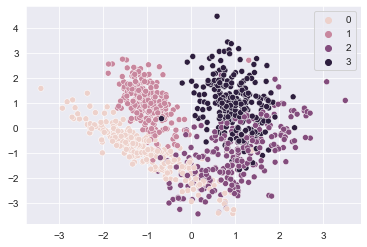

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

np.random.seed(420)
X, y = make_classification(n_samples=1000, n_features=2, n_classes=4, n_redundant=0, n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [4]:
def predict_plane(X, y_true, model, points=100):
    
    x1 = np.array([np.linspace(min(X[:, 0]), max(X[:, 0]), points) for _ in range(points)]).flatten()
    x2 = np.array([np.linspace(min(X[:, 1]), max(X[:, 1]), points) for _ in range(points)]).T.flatten()
    y = model.predict(np.stack((x1, x2)).T)
    sns.scatterplot(x=x1, y=x2, hue=y)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_true)

In [11]:
dt = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
dt.score(X_test, y_test)

0.835

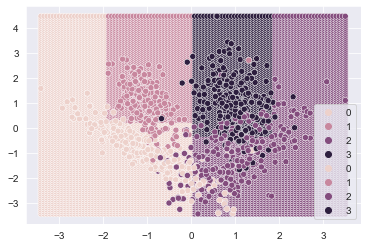

In [12]:
predict_plane(X, y, dt)

## Bootstrap

$\forall_{b\in\{1,2,\ldots,B\}}X^{(b)}$ - bootstrap sample of size $n$ \
Every $X^{(b)}$ is created as sampling $n$ from $n$ observations **with replacement** \
As a result we can build more estimators based on the same data! Averaging it, we may eventually get lower variance.

![](media/bootstrap.png)

## Bagging (Bootstrap Aggregating)

Algorithm:

- Create B bootstrap samples
- Train a model for each of these samples
- As a result for new data, get average/mode of predicted results

![](media/bagging.png)

Bagging is used mainly to reduce variance of a base model. For example, given single and relatively deep decision tree tends to have low bias and high variance. After bagging, the variance of the final estimator should decrease. However, we lose most of the interpretability of our model.

In [15]:
from sklearn.ensemble import BaggingClassifier

N = 100
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=N).fit(X_train, y_train)
bagging.score(X_test, y_test)

0.87

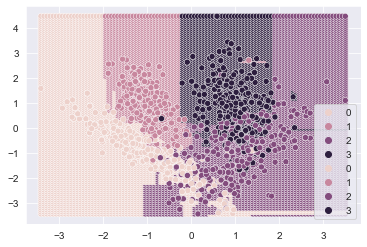

In [16]:
predict_plane(X, y, bagging)

## Random Forest

Algorithm:
- Create B bootstrap samples
- Train a model for each $X^{(b)}$ of these samples but only with $p^{(b)}$ features 
- As a result for new data, get average of predicted results

Typically, $p^{(b)}$ is randomly selected $\sqrt{p}$ features for classification and $\frac{p}{3}$ for regression.
![](media\random_forest.png)

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=N, oob_score=True).fit(X_train, y_train)
rf.score(X_test, y_test)

0.885

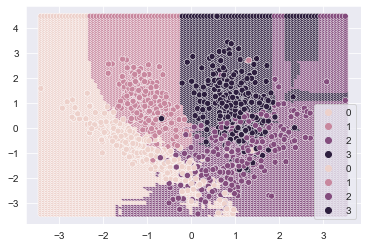

In [20]:
predict_plane(X, y, rf)

### OOB (Out-of-Bag)

$$\forall_{b\in\{1,2,\ldots,B\}}\:OOB^{(b)}=X\setminus X^{(b)}$$ \
Validation set for random forest is created as sequence of $OOB$ sets.

In [21]:
rf.oob_score_

0.83625

### Feature Importance

#### MDI (Mean Decrease in Impurity)

Based on a split measure (for example Gini Impurity) we can calculate mean of Information Gain for each variable across all trees weighted by number of observations that fall into the nodes.

In [22]:
rf.feature_importances_

array([0.5727697, 0.4272303])

#### MDA (Mean Decrease in Accuracy)

For each permutation we randomly drop a variable and calculate how worse accuracy we have in comparison to the model with all variables.

In [23]:
from sklearn.inspection import permutation_importance

permutation_importance(rf, X_test, y_test)

{'importances_mean': array([0.506, 0.362]),
 'importances_std': array([0.03666061, 0.01720465]),
 'importances': array([[0.535, 0.445, 0.545, 0.52 , 0.485],
        [0.39 , 0.36 , 0.34 , 0.37 , 0.35 ]])}

In [24]:
permutation_importance(dt, X_test, y_test)

{'importances_mean': array([0.434, 0.332]),
 'importances_std': array([0.02437212, 0.01939072]),
 'importances': array([[0.395, 0.44 , 0.47 , 0.44 , 0.425],
        [0.35 , 0.32 , 0.32 , 0.36 , 0.31 ]])}

## Boosting

Algorithm (general idea):
- Create bootstrap sample $X^{(1)}$ with $w_i^{(1)}=\frac{1}{n}$ probability for each observation
- Train $f^{(1)}$ model and calculate the error/accuracy
- Based on the calculations update $\forall_{i\in\{1,2,\ldots,n\}}\:w_i$
- Repeat bootstrapping and training models $B$ times
- Average weighted predictions for new data based on training set errors

![](media/boosting.png)

### AdaBoost

Algorithm:
- Let $\forall_{i\in\{1,\ldots,n\}}\:w_i=\frac{1}{n}$
- Train stump $h_1(X)$ (decision tree with only $1$ split) on bootstrap sample according to $w_i$
- Calculate mean error $\varepsilon_1=\frac{\sum_{i=1}^n{w_i1_{h_1(X_i)\neq y_i}}}{\sum_{i=1}^n{w_i}}$
- Compute contribution of the stump $\gamma_1=\frac{1}{2}\ln{\frac{1-\varepsilon_1}{\varepsilon_1}}$
- Reassign the weights $w_i:=w_ie^{-\gamma_1h_1(X_i)y_i}$
- Normalize weights such as $\sum_{i=1}^n{w_i}=1$
- Repeat the training process for new stump according to reassigned weights up to all $M$ stumps

$F(X)=\operatorname{sign}{\left(\sum_{m=1}^M{\gamma_mh_m(X)}\right)}$ - Prediction

![](media/ada.png)

In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=N).fit(X_train, y_train)
ada.score(X_test, y_test)

0.73

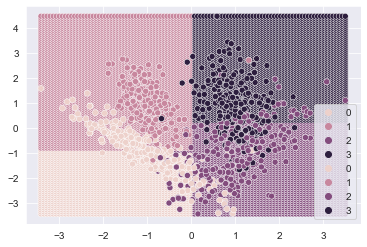

In [27]:
predict_plane(X, y, ada)

### Gradient Boosting

$L(y,f(X))$ - loss function
Algorithm
- Train base model $F_0(X)=\operatorname{argmin}_\gamma\sum_{i=1}^n{L(y_i,\gamma)}$
- Calculate gradient $r_{i1}=-\frac{\partial L(y_i,F_0(X_i))}{\partial F_0(X_i)}$
- Train new base model $h_1$ on the train set $\{(X_i,r_{i1}\}_{i=1}^n$
- Calculate the weight for this model $\gamma_1=\operatorname{argmin}_{\gamma}{\sum_{i=1}^n{L(y_i,F_0(X_i)+\gamma h_1(X_i)}}$
- Update model $F_1(X)=F_0(X)+\gamma_1h_1(X)$
- Repeat for all $M$ models to get final $F_M(X)=F_0(X)+\sum_{m=1}^M{\gamma_mh_m(X)}=F_{M-1}+\gamma_Mh_M(X)$ model

![](media/gbm.png)

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(n_estimators=N).fit(X_train, y_train)
gbm.score(X_test, y_test)

0.85

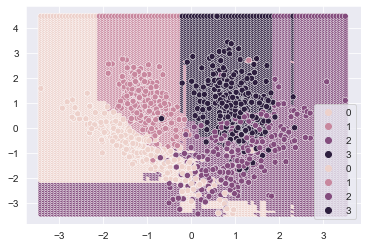

In [29]:
predict_plane(X, y, gbm)

### Other Boosting Algorithms

[LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html) \
[CatBoost](https://catboost.ai/en/docs/) \
[XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)

## Voting

$f^{(1)}(X),f^{(2)}(X),\ldots,f^{(m)}(X)$ - base models \
$\alpha_1,\alpha_2,\ldots,\alpha_m$ - weights (importance) of each model (often $\forall_{i\in\{1,2,\ldots,m\}}\:\alpha_i=\frac{1}{m}$ \
$f(X)=\sum_{i=1}^m{\alpha_if^{(i)}(X)}$ - final model

![](media/voting.png)

In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

voting = VotingClassifier([('dt', DecisionTreeClassifier()),
                           ('lr', LogisticRegression())], voting='soft', weights=[1, 3]).fit(X_train, y_train)
voting.score(X_test, y_test)

0.82

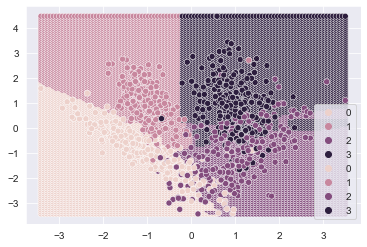

In [36]:
predict_plane(X, y, voting)

## Stacking

$f^{(1)}(X),f^{(2)}(X),\ldots,f^{(m)}(X)$ - base models \
$F(X)=f\left(f^{(1)}(X),f^{(2)}(X),\ldots,f^{(m)}(X)\right)$ - final model

![](media/stacking.png)

In [38]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

stacking = StackingClassifier([('dt', DecisionTreeClassifier()),
                                ('lr', LogisticRegression())], KNeighborsClassifier(3)).fit(X_train, y_train)
stacking.score(X_test, y_test)

0.82

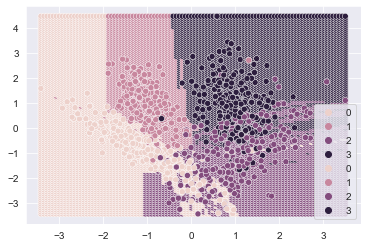

In [39]:
predict_plane(X, y, stacking)